# **Predicting Pulsar Stars**

In [1]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from functools import *
from google.colab import files

np.set_printoptions(formatter = {'float': '{: 0.1f}'.format})

In [2]:
# Uploading files [pulsar_stars.csv]
# Source: https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star
file_name = 'pulsar_stars.csv'
uploaded = files.upload()

Saving pulsar_stars.csv to pulsar_stars.csv


#### **Exploratory Data Analysis (EDA)**

In [0]:
# Loading the dataset
dataset = pd.read_csv(file_name, delimiter=',')

In [4]:
# Exploring the dataset
print("Number of Example (rows): %s" % dataset.shape[0])
print("Number of Features (columns): %s" % dataset.shape[1])

Number of Example (rows): 17898
Number of Features (columns): 9


In [5]:
# Inspecting the dataset
dataset.columns = ['mean_profile', 'standard_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr', 'standard_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr', 'target']
dataset.head()

,mean_profile,standard_profile,kurtosis_profile,skewness_profile,mean_dmsnr,standard_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [6]:
# View data types
dataset.info()

# Check if dataset free from null values
print('')
dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
mean_profile        17898 non-null float64
standard_profile    17898 non-null float64
kurtosis_profile    17898 non-null float64
skewness_profile    17898 non-null float64
mean_dmsnr          17898 non-null float64
standard_dmsnr      17898 non-null float64
kurtosis_dmsnr      17898 non-null float64
skewness_dmsnr      17898 non-null float64
target              17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB



mean_profile        0
standard_profile    0
kurtosis_profile    0
skewness_profile    0
mean_dmsnr          0
standard_dmsnr      0
kurtosis_dmsnr      0
skewness_dmsnr      0
target              0
dtype: int64

#### **Visualize the distribution of each input features**

Range of the values (min, max, mean, median, etc.)

In [7]:
# Basic statistical details like percentile, mean, std etc. of a data frame
dataset.describe()

,mean_profile,standard_profile,kurtosis_profile,skewness_profile,mean_dmsnr,standard_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


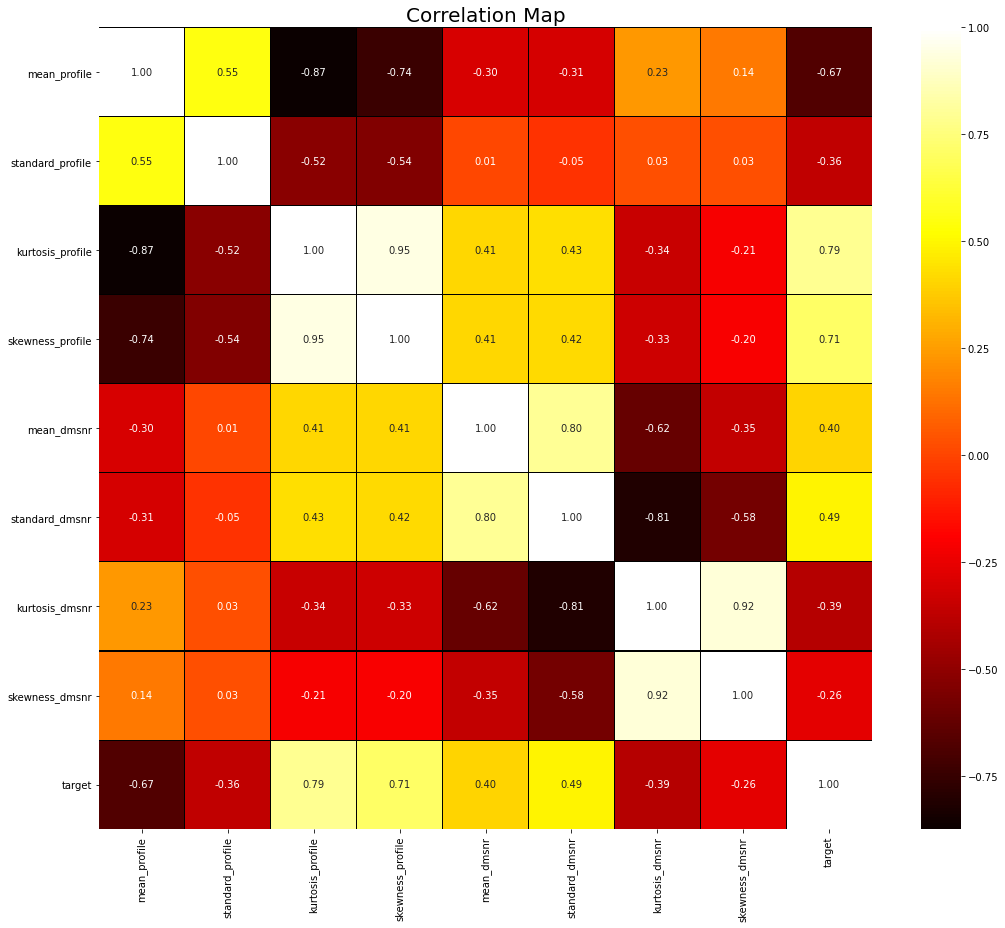

In [8]:
# Correlation between fields
plt.figure(figsize=(15, 13))
sns.heatmap(data=dataset.corr(), annot=True, cmap="hot", linewidths=0.1, fmt=".2f", linecolor="black")
plt.title("Correlation Map", fontsize=20)
plt.tight_layout()
plt.show()

Histograms distribution of each input features

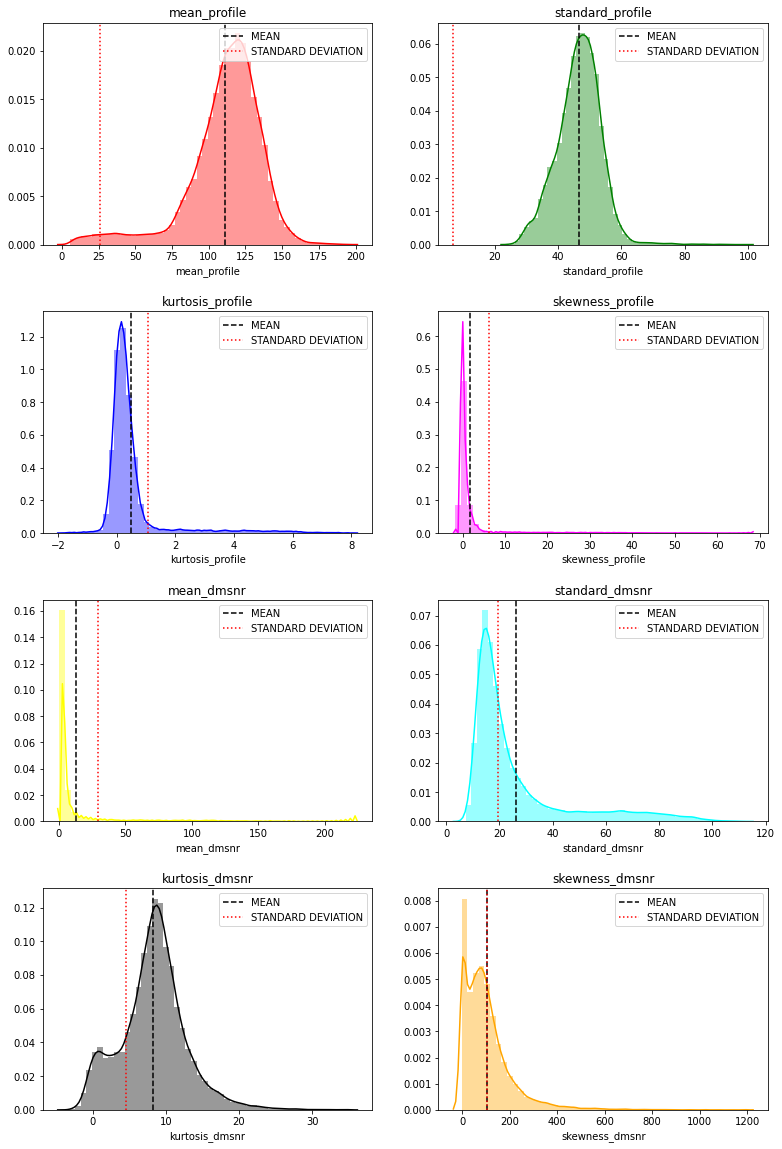

In [9]:
columns = ['mean_profile', 'standard_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr', 'standard_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr']
columns_length  = len(columns)
columns_colors  = ["red", "green", "blue", "magenta", "yellow", "cyan", "black", "orange"] 

# Make an iterator that aggregates elements from each of the iterables
import itertools
plt.figure(figsize=(13, 20))
for i, j, k in itertools.zip_longest(columns, range(columns_length), columns_colors):
    plt.subplot(columns_length/2, columns_length/4, j + 1)
    sns.distplot(dataset[i], color = k)
    plt.title(i)
    plt.subplots_adjust(hspace = 0.3)
    plt.axvline(dataset[i].mean(), color = "black", linestyle="dashed", label="MEAN")
    plt.axvline(dataset[i].std(), color = "red", linestyle="dotted", label="STANDARD DEVIATION")
    plt.legend(loc="upper right")

#### **Distribution of the output labels**
The data is imbalanced and will need to be resampled, such as oversampling, undersampling, or generate synthetic samples.

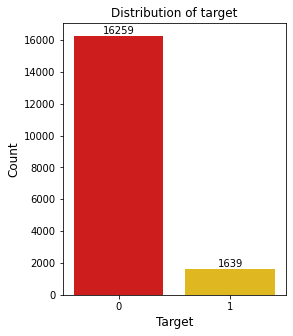

In [10]:
# Distribution of target class
plt.figure(figsize=(4, 5))
axs = sns.countplot(dataset['target'], palette='hot')
plt.title('Distribution of target', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Count Annotation
for rec in axs.patches:
    axs.annotate(format(rec.get_height(), '.0f'), (rec.get_x() + rec.get_width() / 2.0, rec.get_height()), ha='center', va='center', xytext=(0, 5), textcoords = 'offset points', fontsize=10)

#### **Training and Validation Sets**

In [0]:
# Shuffle the dataset
# NOTE: shuffle dataframe in-place and reset the index
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Convert Pandas Dataframe to Numpy dArray
dataset_np = dataset.values
X = dataset.drop('target', axis='columns').values
Y = dataset['target'].values

In [12]:
# Index for 20%
index_20percent = int(0.2 * len(dataset_np[:, 0]))  
print(index_20percent)

# Split into validation (20%) and training (80%)
XVALID = X[:index_20percent, :]
YVALID = Y[:index_20percent]

XTRAIN = X[index_20percent:, :]
YTRAIN = Y[index_20percent:]

3579


#### **Data Normalization**

**IMPORTANT**: Do standardization/normalization after spliting into train and test/validation. The reason is to avoid any data leakage. </br>
**Standardization/Normalization Techniques** </br>
* Standardization: typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance). 
* Normalization: typically means rescales the values into a range of [0, 1]
* Normalization is a good technique to use when you do not know the distribution of your data or when you know the distribution is not Gaussian (a bell curve).
* Standardization assumes that your data has a Gaussian (bell curve) distribution. This does not strictly have to be true, but the technique is more effective if your attribute distribution is Gaussian.
* **Source Code**: https://github.com/badriadhikari/AI-2020spring/blob/master/notebooks/normalization_techniques.ipynb

In [0]:
## Mean normalization
min = XTRAIN.min(axis = 0) 
max = XTRAIN.max(axis = 0) 
mean = XTRAIN.mean(axis = 0)
XTRAIN = (XTRAIN - mean) / (max - min)
XVALID = (XVALID - mean) / (max - min)

## Rescaling
Ymax = YTRAIN.max()
YTRAIN = YTRAIN / Ymax
YVALID = YVALID / Ymax

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81c94f0048>,
      dtype=object)

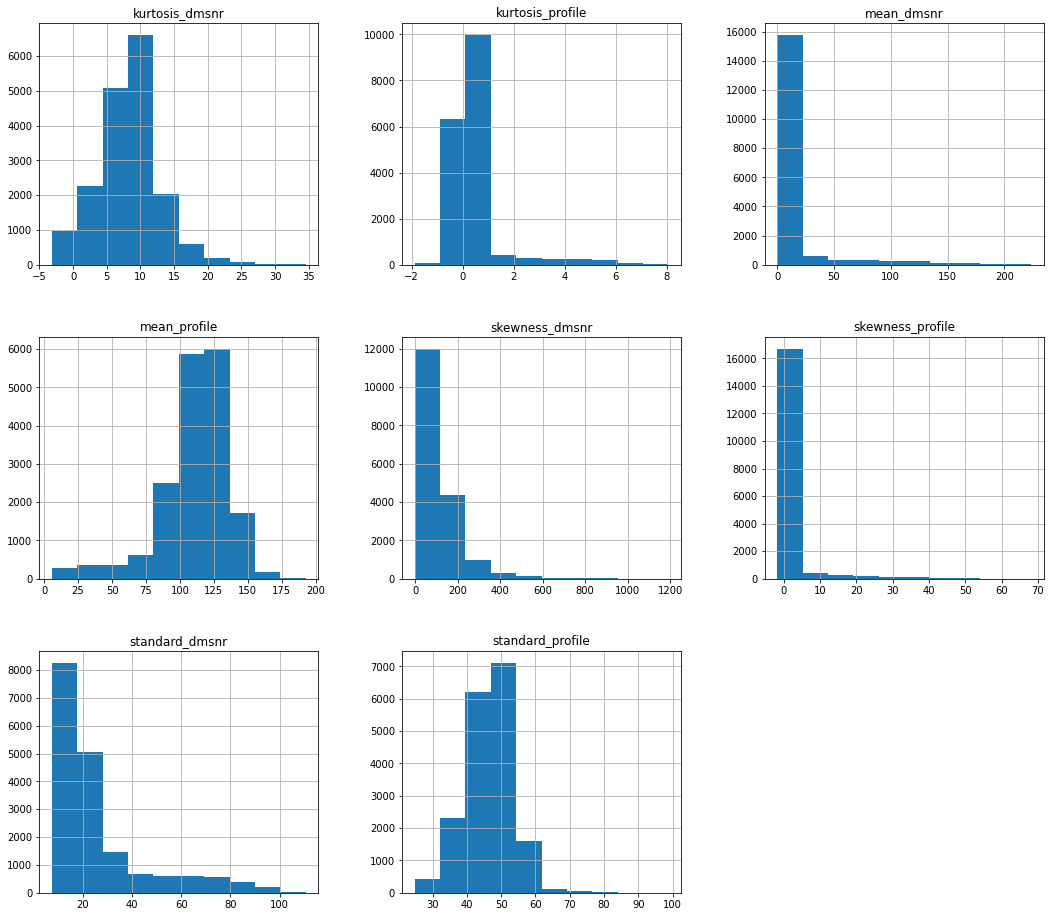

In [14]:
## Verifying
## Before Normalize
dataset.drop('target', axis='columns').hist(figsize=(18,16))

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81c73c8470>,
      dtype=object)

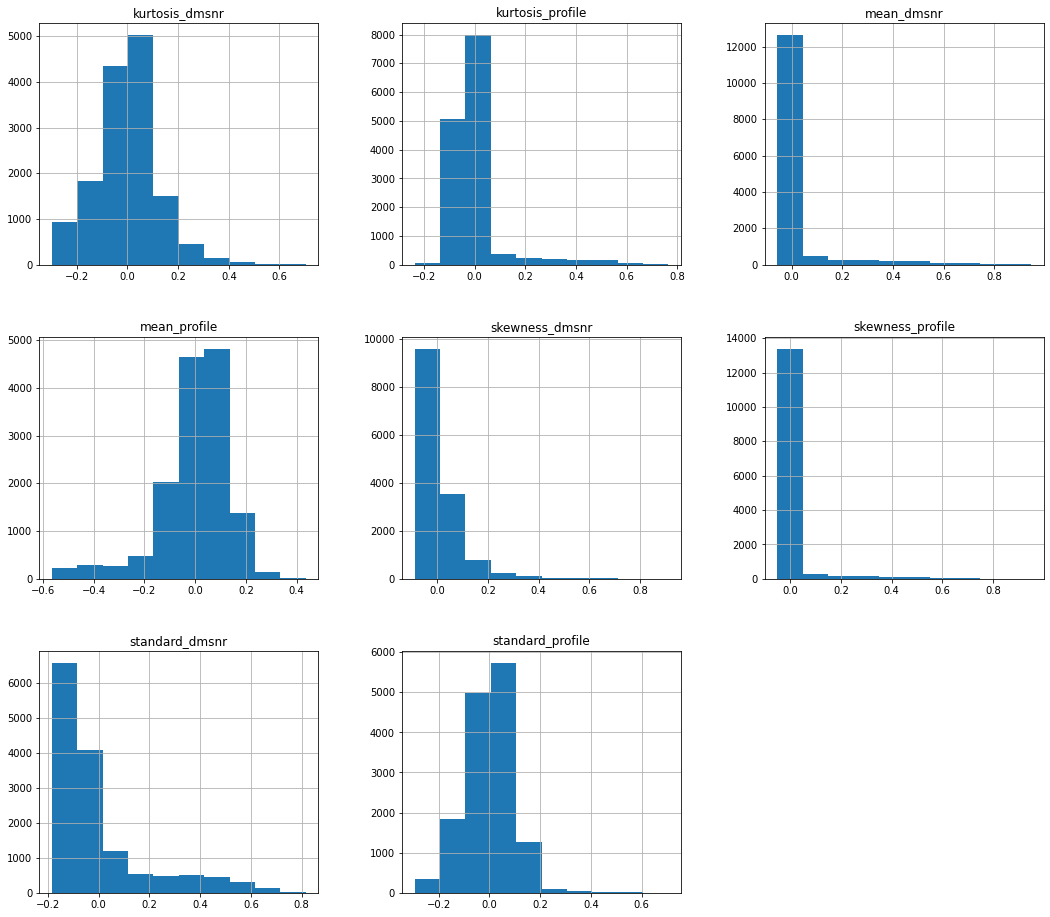

In [15]:
## Verifying
## After Normalize
dfx = pd.DataFrame(data=XTRAIN)
dfx.columns = ['mean_profile', 'standard_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr', 'standard_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr']
dfx.hist(figsize=(18,16))

#### **Neural Network**

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [17]:
## Baseline Model #1
model1 = Sequential()
model1.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
## Baseline Model #2
model2 = Sequential()
model2.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='relu'))
model2.add(Dense(6, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [0]:
## Baseline Model #3
model3 = Sequential()
model3.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='relu'))
model3.add(Dense(6, activation='relu'))
model3.add(Dense(4, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

In [0]:
## Model using linear activation (only last neuron)
modelA = Sequential()
modelA.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='relu'))
modelA.add(Dense(4, activation='relu'))
modelA.add(Dense(1, activation='linear'))

In [0]:
## Model using linear activation (all neurons)
modelB = Sequential()
modelB.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='linear'))
modelB.add(Dense(4, activation='linear'))
modelB.add(Dense(1, activation='linear'))

In [0]:
## Model using sigmoid activation (only last neuron)
modelC = Sequential()
modelC.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='relu'))
modelC.add(Dense(4, activation='relu'))
modelC.add(Dense(1, activation='sigmoid'))

In [0]:
## Model using sigmoid activation (all neurons)
modelD = Sequential()
modelD.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='sigmoid'))
modelD.add(Dense(4, activation='sigmoid'))
modelD.add(Dense(1, activation='sigmoid'))

In [0]:
## Model using sigmoid with leaky relu activation
## The dying ReLU problem happens if the input becomes too large causing the gradient to update the weights such that the summation, and thus the input, will always be less than zero for the rest of the training session.
## Source: https://www.quora.com/What-is-the-dying-ReLU-problem-in-neural-networks
modelE = Sequential()
modelE.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation=partial(tf.nn.leaky_relu, alpha=0.1)))
modelE.add(Dense(4, activation=partial(tf.nn.leaky_relu, alpha=0.1)))
modelE.add(Dense(1, activation='sigmoid'))

In [0]:
## Overfitting Model
modelF = Sequential()
modelF.add(Dense(80, input_dim = len(XTRAIN[0, :]), activation=partial(tf.nn.leaky_relu, alpha=0.1)))
modelF.add(Dense(40, activation=partial(tf.nn.leaky_relu, alpha=0.1)))
modelF.add(Dense(1, activation='sigmoid'))

#### **Compile NN Model**

Binary Classification Loss Functions
* Binary Cross Entropy Loss
* Hinge Loss

**More Info**: 
* https://www.analyticsvidhya.com/blog/2019/08/detailed-guide-7-loss-functions-machine-learning-python-code/
* https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0

Using Adaptive Moment Estimation (Adam) because it automatically tunes itself and gives good results in a wide range of problems. 

In [26]:
## Compile our model
model1.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model2.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model3.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

modelA.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
modelB.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
modelC.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
modelD.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
modelE.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
modelF.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Fitting our model**

**Batch Size**: defines the number of samples that will be propagated through the network. I.e. let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through of the network.

**In general**: Larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. It's definitely problem dependent.

In [0]:
## Baseline Model
history1 = model1.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 0)

In [0]:
history2 = model2.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 0)

In [0]:
history3 = model3.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 0)

In [0]:
## Model using linear activation (only last neuron)
historyA = modelA.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 0)

In [0]:
## Model using linear activation (all neurons)
historyB = modelB.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 0)

In [0]:
## Model using sigmoid activation (only last neuron)
historyC = modelC.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 0)

In [0]:
## Model using sigmoid activation (all neurons)
historyD = modelD.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 0)

In [0]:
## Model using sigmoid with leaky relu activation
historyE = modelE.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 0)

In [0]:
## Overfitting Model
historyF = modelF.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 0)

#### **NN Model Evaluation**
* For Binary Classification only:
    * **Confusion Matrix**: is a simple to layout how many predicted categories or classes were correctly predicted and how many were not.
    * **Goals**: we want as many predictions as possible where more trues than falses.
    * Evaluate the loss value and metrics values for the model in test mode using evaluate function.
    * Predict the output for our valid dataset. If the prediction is greater than 0.5 then the output is 1 else the output is 0.
    * Check the accuracy on the valid dataset with confusion matrix.

**Source:** https://machinelearningmastery.com/confusion-matrix-machine-learning/

In [0]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [0]:
def model_evaluation(xvalid, yvalid, model):
    scores = model.evaluate(xvalid, yvalid)
    for i in range(len(scores)):
        print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

    ypred = model.predict(xvalid)
    ypred = (ypred > 0.5)
    cm = confusion_matrix(yvalid, ypred)
    acc = (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()) * 100
    print("\n%s" % cm)
    print("%s%%\n" % acc)

    accuracy = accuracy_score(yvalid, ypred.round()) * 100.0
    precision = precision_score(yvalid, ypred.round()) * 100.0
    recall = recall_score(yvalid, ypred.round()) * 100.0
    f1score = f1_score(yvalid, ypred.round())

    print("Accuracy: %.2f%%" % (accuracy))
    print("Precision: %.2f%%" % (precision))
    print("Recall: %.2f%%" % (recall))
    print("F1-score: %.2f\n" % (f1score))

    for i in range(10):
	    print("X=%s, Predicted=%s" % (XVALID[i], ypred[i]))
    return ypred

In [82]:
## Baseline Model
ypred1 = model_evaluation(XVALID, YVALID, model1)

3579/3579 [==============================] - 0s 69us/sample - loss: 0.0668 - acc: 0.9807
loss: 6.68%
acc: 98.07%

[[3209   21]
 [  48  301]]
98.0720871751886%

Accuracy: 98.07%
Precision: 93.48%
Recall: 86.25%
F1-score: 0.90

X=[ 0.2  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2  0.1 -0.1 -0.0  0.1  0.2 -0.2 -0.1], Predicted=[False]
X=[-0.3 -0.2  0.2  0.1  0.1  0.4 -0.2 -0.1], Predicted=[ True]
X=[ 0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.0  0.1 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.0 -0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[ 0.1  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.1  0.2 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.1 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[-0.1 -0.0 -0.0 -0.0 -0.0  0.1 -0.1 -0.1], Predicted=[False]


In [83]:
ypred2 = model_evaluation(XVALID, YVALID, model2)

3579/3579 [==============================] - 0s 122us/sample - loss: 0.0646 - acc: 0.9816
loss: 6.46%
acc: 98.16%

[[3211   19]
 [  47  302]]
98.15590947191953%

Accuracy: 98.16%
Precision: 94.08%
Recall: 86.53%
F1-score: 0.90

X=[ 0.2  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2  0.1 -0.1 -0.0  0.1  0.2 -0.2 -0.1], Predicted=[False]
X=[-0.3 -0.2  0.2  0.1  0.1  0.4 -0.2 -0.1], Predicted=[ True]
X=[ 0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.0  0.1 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.0 -0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[ 0.1  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.1  0.2 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.1 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[-0.1 -0.0 -0.0 -0.0 -0.0  0.1 -0.1 -0.1], Predicted=[False]


In [84]:
ypred3 = model_evaluation(XVALID, YVALID, model3)

3579/3579 [==============================] - 0s 83us/sample - loss: 0.0632 - acc: 0.9816
loss: 6.32%
acc: 98.16%

[[3212   18]
 [  48  301]]
98.15590947191953%

Accuracy: 98.16%
Precision: 94.36%
Recall: 86.25%
F1-score: 0.90

X=[ 0.2  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2  0.1 -0.1 -0.0  0.1  0.2 -0.2 -0.1], Predicted=[False]
X=[-0.3 -0.2  0.2  0.1  0.1  0.4 -0.2 -0.1], Predicted=[ True]
X=[ 0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.0  0.1 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.0 -0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[ 0.1  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.1  0.2 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.1 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[-0.1 -0.0 -0.0 -0.0 -0.0  0.1 -0.1 -0.1], Predicted=[False]


In [85]:
## Model using linear activation (only last neuron)
ypredA = model_evaluation(XVALID, YVALID, modelA)

3579/3579 [==============================] - 0s 75us/sample - loss: 0.0148 - mean_absolute_error: 0.0339
loss: 1.48%
mean_absolute_error: 3.39%

[[3211   19]
 [  44  305]]
98.23973176865046%

Accuracy: 98.24%
Precision: 94.14%
Recall: 87.39%
F1-score: 0.91

X=[ 0.2  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2  0.1 -0.1 -0.0  0.1  0.2 -0.2 -0.1], Predicted=[False]
X=[-0.3 -0.2  0.2  0.1  0.1  0.4 -0.2 -0.1], Predicted=[ True]
X=[ 0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.0  0.1 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.0 -0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[ 0.1  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.1  0.2 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.1 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[-0.1 -0.0 -0.0 -0.0 -0.0  0.1 -0.1 -0.1], Predicted=[False]


In [86]:
## Model using linear activation (all neurons)
ypredB = model_evaluation(XVALID, YVALID, modelB)

3579/3579 [==============================] - 0s 66us/sample - loss: 0.0252 - mean_absolute_error: 0.0928
loss: 2.52%
mean_absolute_error: 9.28%

[[3220   10]
 [  88  261]]
97.26180497345626%

Accuracy: 97.26%
Precision: 96.31%
Recall: 74.79%
F1-score: 0.84

X=[ 0.2  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2  0.1 -0.1 -0.0  0.1  0.2 -0.2 -0.1], Predicted=[False]
X=[-0.3 -0.2  0.2  0.1  0.1  0.4 -0.2 -0.1], Predicted=[ True]
X=[ 0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.0  0.1 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.0 -0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[ 0.1  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.1  0.2 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.1 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[-0.1 -0.0 -0.0 -0.0 -0.0  0.1 -0.1 -0.1], Predicted=[False]


In [87]:
## Model using sigmoid activation (only last neuron)
ypredC = model_evaluation(XVALID, YVALID, modelC)

3579/3579 [==============================] - 0s 74us/sample - loss: 0.0674 - acc: 0.9810
loss: 6.74%
acc: 98.10%

[[3209   21]
 [  47  302]]
98.10002794076557%

Accuracy: 98.10%
Precision: 93.50%
Recall: 86.53%
F1-score: 0.90

X=[ 0.2  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2  0.1 -0.1 -0.0  0.1  0.2 -0.2 -0.1], Predicted=[False]
X=[-0.3 -0.2  0.2  0.1  0.1  0.4 -0.2 -0.1], Predicted=[ True]
X=[ 0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.0  0.1 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.0 -0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[ 0.1  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.1  0.2 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.1 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[-0.1 -0.0 -0.0 -0.0 -0.0  0.1 -0.1 -0.1], Predicted=[False]


In [88]:
## Model using sigmoid activation (all neurons)
ypredD = model_evaluation(XVALID, YVALID, modelD)

3579/3579 [==============================] - 0s 76us/sample - loss: 0.0673 - acc: 0.9813
loss: 6.73%
acc: 98.13%

[[3210   20]
 [  47  302]]
98.12796870634256%

Accuracy: 98.13%
Precision: 93.79%
Recall: 86.53%
F1-score: 0.90

X=[ 0.2  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2  0.1 -0.1 -0.0  0.1  0.2 -0.2 -0.1], Predicted=[False]
X=[-0.3 -0.2  0.2  0.1  0.1  0.4 -0.2 -0.1], Predicted=[ True]
X=[ 0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.0  0.1 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.0 -0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[ 0.1  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.1  0.2 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.1 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[-0.1 -0.0 -0.0 -0.0 -0.0  0.1 -0.1 -0.1], Predicted=[False]


In [89]:
## Model using sigmoid with leaky relu activation
ypredE = model_evaluation(XVALID, YVALID, modelE)

3579/3579 [==============================] - 0s 73us/sample - loss: 0.0634 - acc: 0.9821
loss: 6.34%
acc: 98.21%

[[3210   20]
 [  44  305]]
98.21179100307349%

Accuracy: 98.21%
Precision: 93.85%
Recall: 87.39%
F1-score: 0.91

X=[ 0.2  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2  0.1 -0.1 -0.0  0.1  0.2 -0.2 -0.1], Predicted=[False]
X=[-0.3 -0.2  0.2  0.1  0.1  0.4 -0.2 -0.1], Predicted=[ True]
X=[ 0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.0  0.1 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.0 -0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[ 0.1  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.1  0.2 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.1 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[-0.1 -0.0 -0.0 -0.0 -0.0  0.1 -0.1 -0.1], Predicted=[False]


In [90]:
## Overfitting Model
ypredF = model_evaluation(XVALID, YVALID, modelF)

3579/3579 [==============================] - 0s 95us/sample - loss: 0.0614 - acc: 0.9835
loss: 6.14%
acc: 98.35%

[[3212   18]
 [  41  308]]
98.35149483095836%

Accuracy: 98.35%
Precision: 94.48%
Recall: 88.25%
F1-score: 0.91

X=[ 0.2  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2  0.1 -0.1 -0.0  0.1  0.2 -0.2 -0.1], Predicted=[False]
X=[-0.3 -0.2  0.2  0.1  0.1  0.4 -0.2 -0.1], Predicted=[ True]
X=[ 0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.0  0.1 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.0 -0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[ 0.1  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.1  0.2 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.1 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[-0.1 -0.0 -0.0 -0.0 -0.0  0.1 -0.1 -0.1], Predicted=[False]


#### **Learning curves**

In [0]:
def learning_curves_logistic(model_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(model_history.history['loss'])
    ax1.plot(model_history.history['val_loss'])
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['training loss data', 'validation loss data'], loc='lower right')

    ax2.plot(model_history.history['acc'])
    ax2.plot(model_history.history['val_acc'])
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')

    fig.show()

In [0]:
def learning_curves_linear(model_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(model_history.history['loss'])
    ax1.plot(model_history.history['val_loss'])
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['training loss data', 'validation loss data'], loc='lower right')

    ax2.plot(model_history.history['mean_absolute_error'])
    ax2.plot(model_history.history['val_mean_absolute_error'])
    ax2.set_ylabel('error')
    ax2.set_xlabel('epoch')
    ax2.legend(['training error data', 'validation error data'], loc='lower right')

    fig.show()

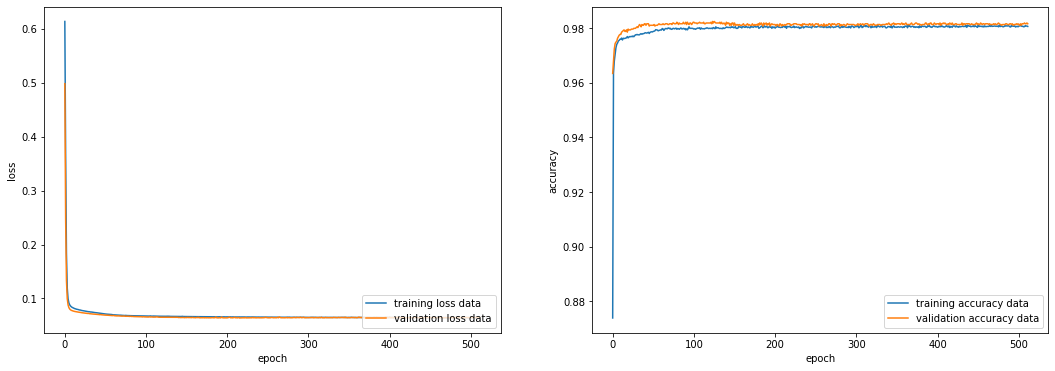

In [49]:
## Baseline Model
learning_curves_logistic(history2)

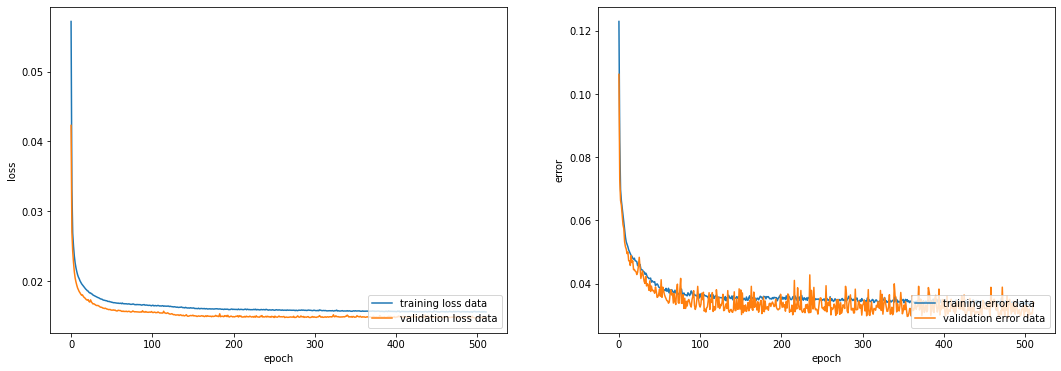

In [50]:
## Model using linear activation (only last neuron)
learning_curves_linear(historyA)

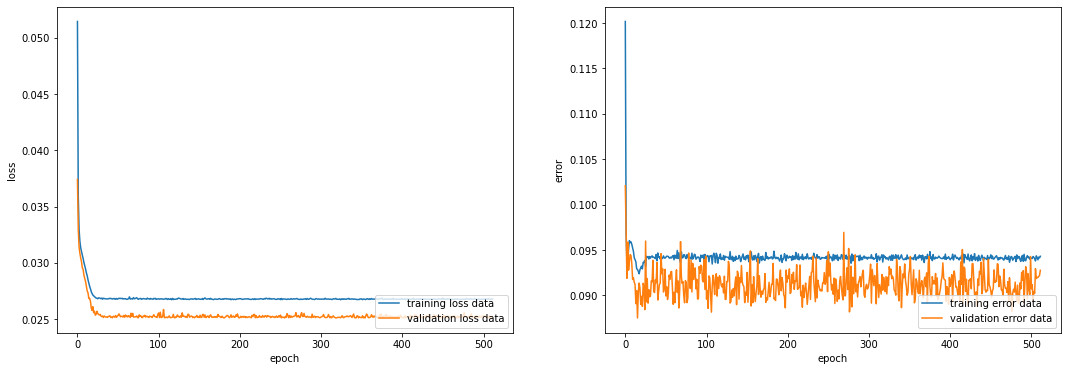

In [51]:
## Model using linear activation (all neurons)
learning_curves_linear(historyB)

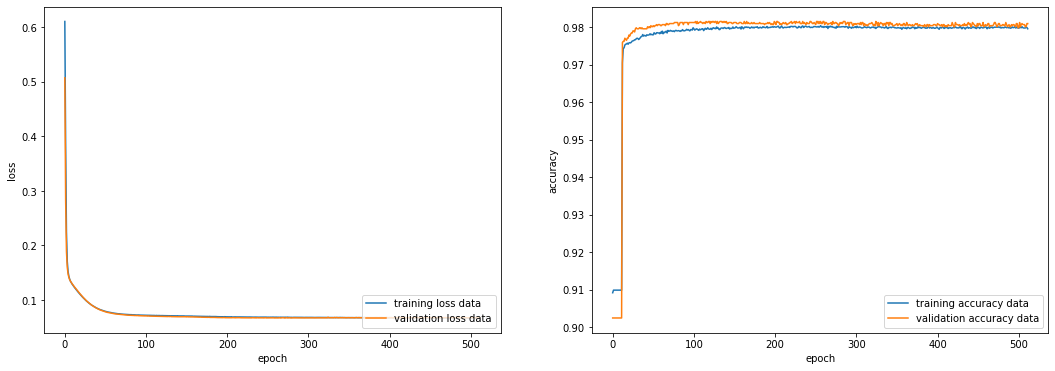

In [52]:
## Model using sigmoid activation (only last neuron)
learning_curves_logistic(historyC)

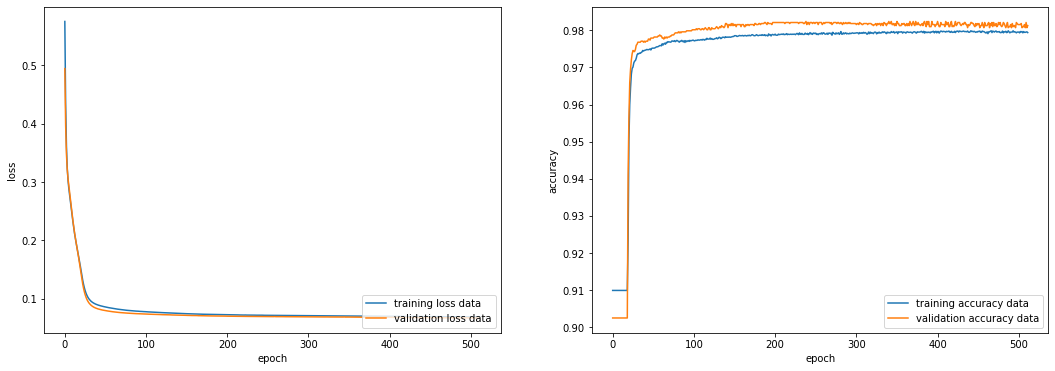

In [53]:
## Model using sigmoid activation (all neurons)
learning_curves_logistic(historyD)

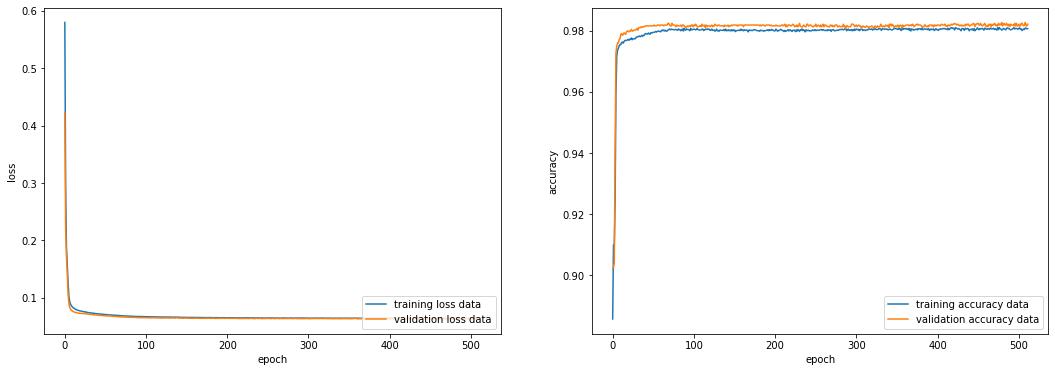

In [54]:
## Model using sigmoid with leaky relu activation
learning_curves_logistic(historyE)

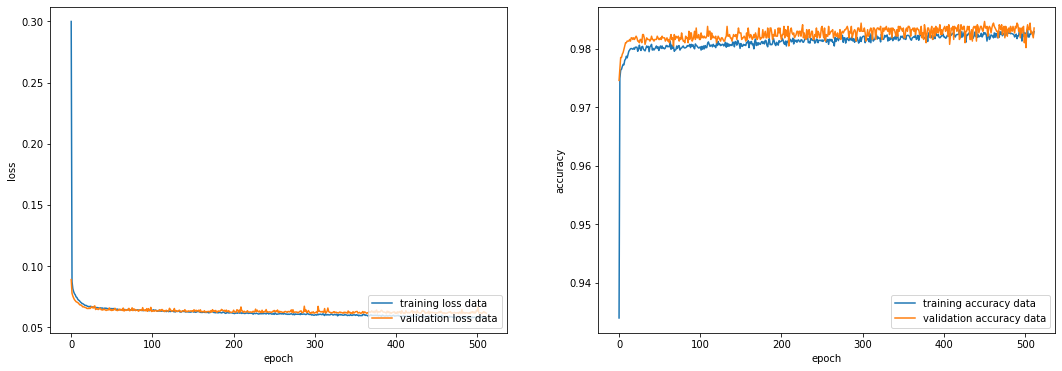

In [55]:
## Overfitting Model
learning_curves_logistic(historyF)

#### **Model Performances**
**What Are ROC Curves?** A useful tool when predicting the probability of a binary outcome is the Receiver Operating Characteristic curve, or ROC curve. The area covered by the curve is the area between the red line and the axis. This area covered is AUC. The bigger the area covered, the better the machine learning models is at distinguishing the given classes. In other words, the AUC can be used as a summary of the model skill. Ideal value for AUC is 1.

**Test accuracy** The closer the graph is to the top and left-hand borders, the more accurate the test. Likewise, the closer the graph to the diagonal, the less accurate the test. A perfect test would go straight from zero up the the top-left corner and then straight across the horizontal.

**Source:** https://stackabuse.com/understanding-roc-curves-with-python/

In [0]:
def model_performances(yvalid, ypred, title="ROC Curve"):
    fpr, tpr, thresholds = roc_curve(YVALID, ypred)
    plt.plot([0, 1], [0, 1], linestyle = "dashed" ,color="b")
    plt.plot(fpr, tpr ,color="red", label=('Area under the curve: ', round(auc(fpr, tpr), 4)))
    plt.title(title, fontsize=10)
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.legend(loc='best', fontsize=10)

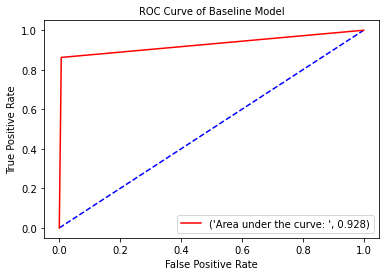

In [57]:
## Baseline Model
model_performances(YVALID, ypred1, 'ROC Curve of Baseline Model')

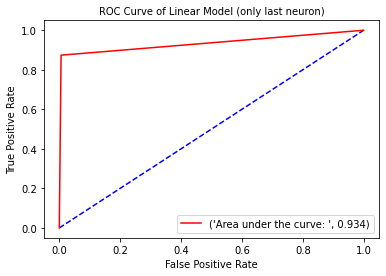

In [58]:
## Model using linear activation (only last neuron)
model_performances(YVALID, ypredA, 'ROC Curve of Linear Model (only last neuron)')

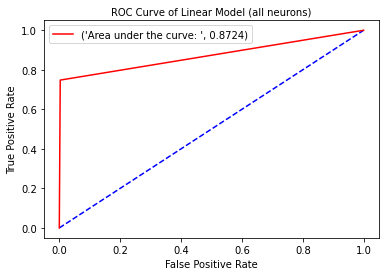

In [59]:
## Model using linear activation (all neurons)
model_performances(YVALID, ypredB, 'ROC Curve of Linear Model (all neurons)')

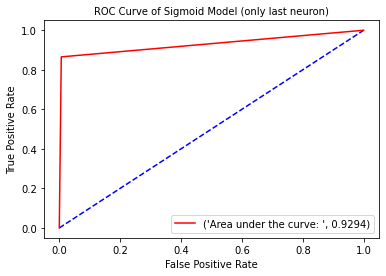

In [92]:
## Model using sigmoid activation (only last neuron)
model_performances(YVALID, ypredC, 'ROC Curve of Sigmoid Model (only last neuron)')

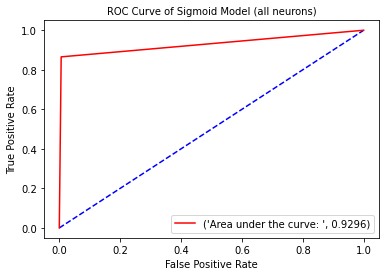

In [61]:
## Model using sigmoid activation (all neurons)
model_performances(YVALID, ypredD, 'ROC Curve of Sigmoid Model (all neurons)')

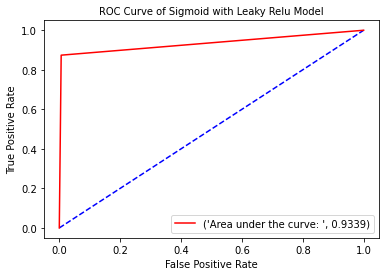

In [62]:
## Model using sigmoid with leaky relu activation
model_performances(YVALID, ypredE, 'ROC Curve of Sigmoid with Leaky Relu Model')

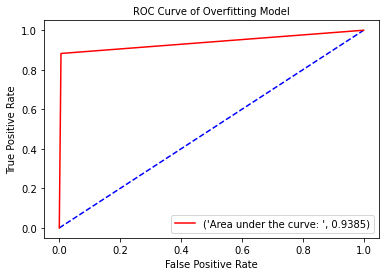

In [63]:
## Overfitting Model
model_performances(YVALID, ypredF, 'ROC Curve of Overfitting Model')

#### **Verifying Model Prediction**
For Model C
* 3 layers
* Input Layers : Relu
* Hidden Layers : Relu
* Output Layers : Sigmoid

In [0]:
# Rectified Linear function
def rectified(x):
	return np.maximum(0, x)

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(np.negative(x)))

def custom_predict(model, validXData, validYData, display_weight=None):
    prediction = validXData
    layTotal = len(model.layers)

    for layNum, lay in enumerate(model.layers):
        weights = lay.get_weights()[0].T
        biases = lay.get_weights()[1].T
        if display_weight is not None:
            print("Layer #%s" %layNum)
            print("Weights:\n %s" % weights)
            print("Bias:\n %s\n" % biases)

        holder = []
        for row in prediction:
            value = []
            for i, w in enumerate(weights):                
                val = np.dot(w, row) + biases[i]
                value.append(val)

            if layNum < layTotal - 1:
                holder.append(rectified(value))
            else:
                holder.append(sigmoid(value))
            
        # Update new input value
        prediction = np.array(holder)
    prediction = (prediction > 0.5)

    accuracy = accuracy_score(validYData, prediction.round()) * 100.0
    precision = precision_score(validYData, prediction.round()) * 100.0
    recall = recall_score(validYData, prediction.round()) * 100.0
    f1score = f1_score(validYData, prediction.round()) * 100.0

    print("Accuracy: %.2f%%" % (accuracy))
    print("Precision: %.2f%%" % (precision))
    print("Recall: %.2f%%" % (recall))
    print("F1-score: %.2f\n" % (f1score))

    for i in range(10):
	    print("X=%s, Predicted=%s" % (validXData[i], prediction[i]))
    return prediction

In [93]:
cypred = custom_predict(modelC, XVALID, YVALID, display_weight=True)

Layer #0
Weights:
 [[ 0.0  0.3 -2.0  1.5 -0.3  0.8 -0.8 -0.4]
 [-0.6  0.8 -2.6  0.7  0.7  0.4 -1.1  0.5]
 [ 0.7  0.1  3.4 -1.1  0.2  0.3  0.9  0.1]
 [ 0.2  0.1  0.0 -0.1 -0.2  0.1  0.3 -0.4]
 [ 0.3  1.1 -1.2  0.5  0.4 -2.2 -0.1  1.3]
 [-1.5  0.0  0.3  1.3  0.6 -2.1  0.2  0.3]
 [ 0.7  0.3  2.8 -0.4  0.5 -0.1  0.2  0.1]
 [ 0.6 -1.1 -3.8  0.4  0.6 -1.1 -1.3  1.1]]
Bias:
 [ 0.5  0.7  0.3 -0.1  0.4  0.1  0.2  0.4]

Layer #1
Weights:
 [[-0.5 -0.1 -0.7 -0.0  0.0 -0.4  0.3 -0.0]
 [ 0.9  1.5 -1.5 -0.5  1.1  1.1 -1.0  2.6]
 [ 1.0  0.2 -1.5 -0.4  1.6  1.5 -1.3  1.5]
 [-8.5 -0.4  0.4 -0.4 -1.7  0.4  0.2 -0.6]]
Bias:
 [-0.1  0.4  0.4  0.4]

Layer #2
Weights:
 [[ 0.4 -1.9 -1.5 -2.6]]
Bias:
 [ 4.6]

Accuracy: 98.10%
Precision: 93.50%
Recall: 86.53%
F1-score: 89.88

X=[ 0.2  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2  0.1 -0.1 -0.0  0.1  0.2 -0.2 -0.1], Predicted=[False]
X=[-0.3 -0.2  0.2  0.1  0.1  0.4 -0.2 -0.1], Predicted=[ True]
X=[ 0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predi

In [66]:
## Model using sigmoid activation (only last neuron)
ypredC = model_evaluation(XVALID, YVALID, modelC)

3579/3579 [==============================] - 0s 76us/sample - loss: 0.0674 - acc: 0.9810
loss: 6.74%

acc: 98.10%

[[3209   21]
 [  47  302]]
98.10002794076557%

Accuracy: 98.10%
Precision: 93.50%
Recall: 86.53%
F1-score: 89.88

X=[ 0.2  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.2  0.1 -0.1 -0.0  0.1  0.2 -0.2 -0.1], Predicted=[False]
X=[-0.3 -0.2  0.2  0.1  0.1  0.4 -0.2 -0.1], Predicted=[ True]
X=[ 0.0 -0.0 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.0  0.1 -0.0 -0.0 -0.0 -0.1  0.0  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.0 -0.0 -0.0 -0.1  0.0 -0.0], Predicted=[False]
X=[ 0.1  0.1 -0.1 -0.0 -0.0 -0.1 -0.0 -0.0], Predicted=[False]
X=[ 0.1  0.2 -0.0 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[ 0.1 -0.0 -0.1 -0.0 -0.0 -0.1  0.1  0.0], Predicted=[False]
X=[-0.1 -0.0 -0.0 -0.0 -0.0  0.1 -0.1 -0.1], Predicted=[False]
